--------------------------------------------------------------------------------

# Machine Learning workflow

* Collecting unbiased data
* Exploratory Data Analysis - To understand the data
* Data augmentation - if required
* Preprocessing - To make our data ready to be passed through the model. Steps include normalization, scaling, image resizing, encoding categorical variables, changing the datatype etc.,
* Model architecture - To design the architecture based on our data. E.g., CNN, RNN, LSTM, SVM classifiers, K-means clustering, etc.,
* Training our model - Updating weights using loss/cost function, backpropagation, optimizers, learning rate, regularization and other techniques.
* Inference - To predict new data using our trained model on the device.
* Postprocessing - Enhancing and visualizing the output to be understoodby people
* Deployment - To deploy it in the real world.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Project objective: To classify dogs and cats

### Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

### Collecting the data

In [ ]:
path = '/content/drive/MyDrive/Datasets/dogs_vs_cats/'

train_dir = os.path.join(path, 'train_data/train')
test_dir = os.path.join(path, 'test_data/test1')
# train_files = os.listdir(train_dir)
# test_files = os.listdir(test_dir)

In [ ]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
len(train_list)

25000

### Visualizing the images:

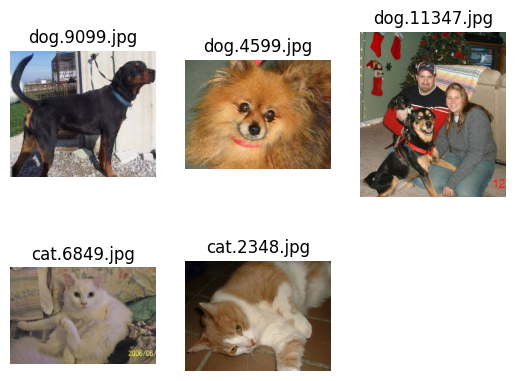

In [ ]:
for idx, image in enumerate(train_list[::5000]):
  plt.subplot(2,3,idx+1)
  plt.imshow(Image.open(image))
  plt.title(image.split('/')[-1])
  plt.axis('off')

### Preprocessing:

* Image resizing, flipping, random color enhancement, target label encoding for categorization.

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

data_transform = transforms.Compose([
    transforms.Resize(256),             # Resizing -> (size * larger_side/smaller_side, size)
    transforms.ColorJitter(),           # Random brightness, contrast etc.,
    transforms.RandomCrop(224),         # Random crop -> 224*224
    transforms.RandomHorizontalFlip(),  # Flipping image horizantally
    transforms.Resize(128),             # Resizing -> (size * larger_side/smaller_side, size). After squared random crop, it will be a square.
    transforms.ToTensor()               # Converting it to tensor
])

cat_files = [tf.split('/')[-1] for tf in train_list if 'cat' in tf.split('/')[-1]]
dog_files = [tf.split('/')[-1] for tf in train_list if 'dog' in tf.split('/')[-1]]

cats_train = CatDogDataset(cat_files[:10000], train_dir, transform = data_transform)
dogs_train = CatDogDataset(dog_files[:10000], train_dir, transform = data_transform)
cats_test = CatDogDataset(cat_files[10000:], train_dir, transform = data_transform)
dogs_test = CatDogDataset(dog_files[10000:], train_dir, transform = data_transform)

train_cd = ConcatDataset([cats_train, dogs_train])
test_cd = ConcatDataset([cats_test, dogs_test])

In [ ]:
print(len(train_cd))
print(len(test_cd))

20000
5000


### Transformation visualization sample

Size of the Original image: (301, 342)
Size of the transformed image: (128, 128)


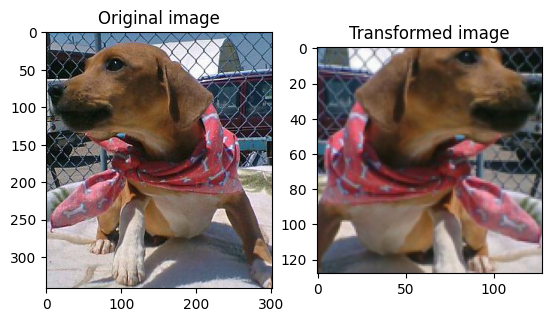

In [ ]:
org_img = Image.open(train_list[4000])
size = org_img.size
print("Size of the Original image:", size)

transform_sample = transforms.Compose([
    transforms.Resize(256),             # Resizing -> (size * larger_side/smaller_side, size)
    transforms.ColorJitter(),           # Random brightness, contrast etc.,
    transforms.RandomCrop(224),         # Random crop -> 224*224
    transforms.RandomHorizontalFlip(),  # Flipping image horizantally
    transforms.Resize(128),             # Resizing -> (size * larger_side/smaller_side, size). After squared random crop, it will be a square.
])

img = transform_sample(org_img)
print("Size of the transformed image:", img.size)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(org_img)
ax1.set_title('Original image')
ax2.imshow(img)
ax2.set_title('Transformed image')
plt.show()

### Defining the mini batch(for faster operation):

In [ ]:
train_dl = DataLoader(train_cd, batch_size = 32, shuffle=True)
test_dl = DataLoader(test_cd, batch_size = 32, shuffle=True)

### Designing the architecture

In [ ]:
class MC(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(2*2*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Hyperparameters tuning

In [ ]:
model = MC()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
n_epoch = 7
print(model)

MC(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (rel

### Training the model

In [ ]:
Train_loss_history = []
Val_loss_history = []
Train_accuracy_history = []
Val_accuracy_history = []
prediction_list = []
label_list = []

for epoch in range(n_epoch):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_label_size = 0
    for i, (data, labels) in enumerate(train_dl):

        optimizer.zero_grad() #Zero the gradients
        output = model(data)  #Forward pass
        train_loss = criterion(output, labels)
        train_loss.backward() #Backward Propagation
        optimizer.step()  #Updating the weights

        total_train_loss+= train_loss.item()
        _, train_prediction = torch.max(output, 1)

        correct_train += (train_prediction == labels).sum()
        total_label_size+= labels.size(0)
        train_accuracy_score = 100 * (correct_train/total_label_size)

    scheduler.step()
    Train_loss_history.append(train_loss.item())
    Train_accuracy_history.append(train_accuracy_score)

    total_val_loss = 0
    correct_val = 0
    label_size = 0
    model.eval()
    for idx, (data, labels) in enumerate(test_dl):

        label_list.append(labels)

        prediction = model(data)
        val_loss = criterion(prediction, labels)
        _, val_prediction = torch.max(prediction, 1)
        correct_val += (val_prediction == labels).sum()
        label_size+= labels.size(0)

        val_accuracy_score = 100 * (correct_val/label_size)


        total_val_loss+= val_loss.item()
        if epoch == n_epoch-1:
          prediction_list.append(val_prediction)

    Val_accuracy_history.append(val_accuracy_score)
    Val_loss_history.append(val_loss.item())
    print(f'Epoch: {epoch+1}: Training_Loss: {total_train_loss/len(train_dl)}, Train_acc: {train_accuracy_score},\
          Val_Loss: {total_val_loss/len(test_dl)}, Val_acc: {val_accuracy_score}')


Epoch: 1: Training_Loss: 0.5958302006721496, Train_acc: 67.69999694824219,          Val_Loss: 0.9555770741526488, Val_acc: 60.02000045776367
Epoch: 2: Training_Loss: 0.512551118516922, Train_acc: 75.13500213623047,          Val_Loss: 0.83092695493607, Val_acc: 60.15999984741211
Epoch: 3: Training_Loss: 0.47050422711372375, Train_acc: 77.41500091552734,          Val_Loss: 0.4327094219862276, Val_acc: 80.13999938964844
Epoch: 4: Training_Loss: 0.44670908586978914, Train_acc: 79.1199951171875,          Val_Loss: 0.4475673160925033, Val_acc: 79.4000015258789
Epoch: 5: Training_Loss: 0.42997977674007415, Train_acc: 80.11500549316406,          Val_Loss: 0.4390114931164274, Val_acc: 79.36000061035156
Epoch: 6: Training_Loss: 0.4181169327020645, Train_acc: 80.69499969482422,          Val_Loss: 0.4233147403237167, Val_acc: 80.77999877929688
Epoch: 7: Training_Loss: 0.39999159581661226, Train_acc: 81.98500061035156,          Val_Loss: 0.3882991448519336, Val_acc: 82.36000061035156


### Visualizing the prediction

In [ ]:
from itertools import chain

predictions_l = [prediction_list[i].tolist() for i in range(len(prediction_list))]
labels_l = [label_list[i].tolist() for i in range(len(label_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

<Axes: >

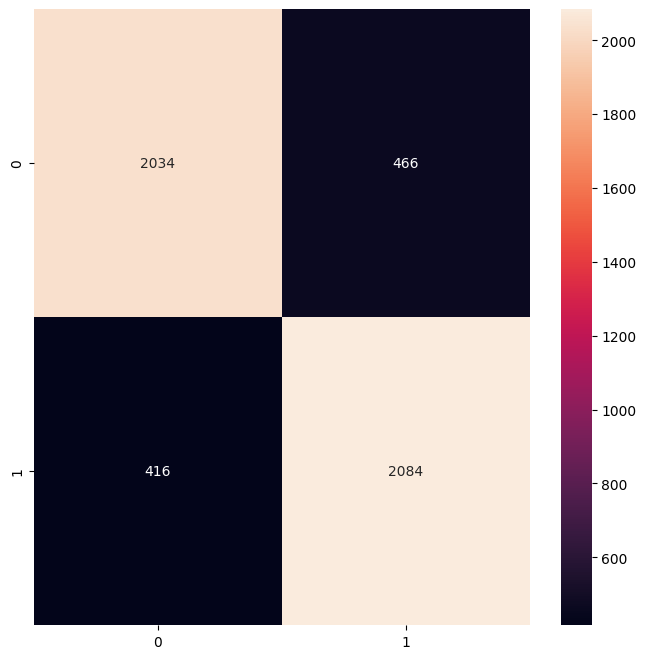

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(labels_l[-5000:], predictions_l), annot = True, fmt = 'g' )

### Observations:
* Class 0 is misclassified 466 times and class 1 is misclassified  416 times.

### Classification report (metrics) to understand how well our model is performing:

In [ ]:
print("Classification report for CNN :\n%s\n" % (classification_report(labels_l[-5000:], predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2500
           1       0.82      0.83      0.83      2500

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000




### Observations:

*   Precison is decent in both classes. Precision means, out of all the images the model predicted as class 0 or class 1, how much it is correct as class 0 or class 1 respectively.
*   Recall is good in both classes too. Recall means, out of all the images from class 0 or class 1 in training data, how much the model has predicted correctly.
*   F1 score is good too as it is the harmonic mean of precision and recall.

### Visualizing model's loss and accuray:

### Loss

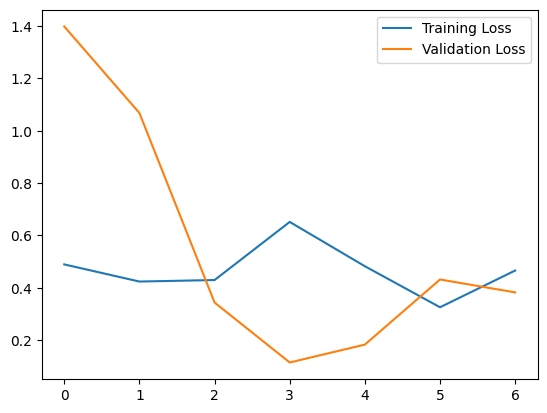

In [ ]:
plt.plot(Train_loss_history, label = 'Training Loss')
plt.plot(Val_loss_history, label = 'Validation Loss')
plt.legend()
plt.show()

### Accuracy

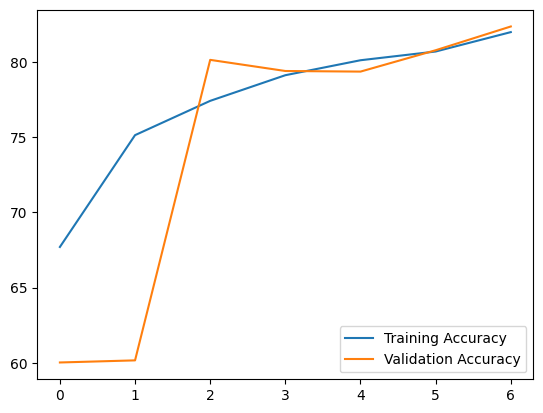

In [ ]:
plt.plot(Train_accuracy_history, label = 'Training Accuracy')
plt.plot(Val_accuracy_history, label = 'Validation Accuracy')
plt.legend()
plt.show()

# Model Performance:

### Model 1:


**Architecture:**
```
MC(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)
```
**Hyperparameters:**


```
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
n_epoch = 7
```





### Metrics:

*  Validation samples     : 5000 (Each class has 2500 samples)
*  Class 0 Predicted      : 2034  
*  Class 1 Predicted      : 2084
*  Training Accuracy      : 81.98
*  Validataion Accuracy   : 82.36
*  Class 0 False Positive : 416 (Which is Class 1 False Negative)
*  Class 0 False Negative : 466 (Which is Class 1 False Positive)
*  Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2500
           1       0.82      0.83      0.83      2500


### Model 2:

**Architecture:**

*Architecture after removing layer 3 from model 1:*

```
MC(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)
```
**Hyperparameters:**


```
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
n_epoch = 7
```
### Metrics

*  Validation samples      : 5000 (Each class has 2500 samples)
*  Class 0 Predicted       : 2091
*  Class 1 Predicted       : 1866
*  Training Accuracy       : 78.99
*  Validataion Accuracy    : 79.13
*  Class 0 False Positive  : 634 (Which is Class 1 False Negative)
*  Class 0 False Negative  : 409 (Which is Class 1 False Positive)
*  Classification report:
             precision    recall  f1-score   support

           0       0.77      0.84      0.80      2500
           1       0.82      0.75      0.78      2500

**Observation**

* Precision in Class 0 comparatively lesser than Class 1.
* Recall in Class 1 is lesser than Class 0.

### Model 3:

**Architecture:**

*Constructing more channels(feature maps) than above models with three convnet sequential layers:*

```
MC(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)
```
**Hyperparameters:**


```
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
n_epoch = 7
```
### Metrics

*  Validation samples      : 5000 (Each class has 2500 samples)
*  Class 0 Predicted       : 2161
*  Class 1 Predicted       : 2021
*  Training Accuracy       : 83.63
*  Validataion Accuracy    : 83.16
*  Class 0 False Positive: 479 (Which is Class 1 False Negative)
*  Class 0 False Negative: 339 (Which is Class 1 False Positive)
*  Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2500
           1       0.84      0.81      0.82      2500